In [1]:
import functools
import numpy as np
import sympy
import matplotlib.pyplot as plt
import keras
import keras.backend as K
sympy.init_printing()

Using TensorFlow backend.


In [125]:
a = sympy.symbols('a')
F = sympy.cos(a) * sympy.exp(-a**2/1000) + sympy.exp(-a**2/4) + 1.5
dF = F.diff(a)
lambda_F = sympy.lambdify((a,), F)
lambda_dF = sympy.lambdify((a,), dF)
F, dF

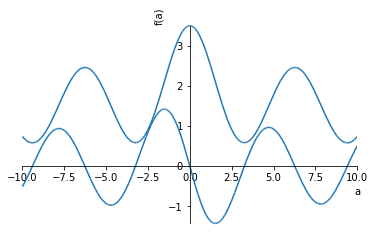

In [126]:
sympy.plot(F, dF)
plt.show()

In [127]:
xtrain = (np.random.random((100000,1)) - 0.5) * 20
xtest = (np.random.random((10000,1)) - 0.5) * 20
ytrain, ytest = lambda_dF(xtrain), lambda_dF(xtest)

In [130]:
X = X_input = keras.layers.Input((1,))
X = keras.layers.BatchNormalization()(X)
X = keras.layers.Dense(32, activation='tanh')(X)
X = keras.layers.Dense(32, activation='tanh')(X)
X = keras.layers.Dense(32, activation='tanh')(X)
X = keras.layers.Dense(32, activation='tanh')(X)
X = keras.layers.Dense(1)(X)
M = keras.Model(X_input, X)
M.compile('adam', 'mse', ['mae'])
M.summary()
X = M(X_input)
X = keras.layers.Lambda(
    lambda x: K.gradients(x[1], x[0])[0] + K.sum(x[1])*0,
    output_shape=(1,))([X_input, X])
G = keras.Model(X_input, X)
G.compile('adadelta', 'mse', ['mae'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_27 (InputLayer)        (None, 1)                 0         
_________________________________________________________________
batch_normalization_34 (Batc (None, 1)                 4         
_________________________________________________________________
dense_121 (Dense)            (None, 32)                64        
_________________________________________________________________
dense_122 (Dense)            (None, 32)                1056      
_________________________________________________________________
dense_123 (Dense)            (None, 32)                1056      
_________________________________________________________________
dense_124 (Dense)            (None, 32)                1056      
_________________________________________________________________
dense_125 (Dense)            (None, 1)                 33        
Total para

In [136]:
G.fit(xtrain, ytrain, validation_data=(xtest, ytest), batch_size=256, epochs=25, callbacks=[
    keras.callbacks.ReduceLROnPlateau(patience=5, verbose=1)
])

Train on 100000 samples, validate on 10000 samples
Epoch 1/25
100000/100000 [==============================] - 3s 27us/step - loss: 0.1100 - mean_absolute_error: 0.2597 - val_loss: 0.1811 - val_mean_absolute_error: 0.3605
Epoch 2/25
100000/100000 [==============================] - 3s 27us/step - loss: 0.1152 - mean_absolute_error: 0.2652 - val_loss: 0.1815 - val_mean_absolute_error: 0.3632
Epoch 3/25
100000/100000 [==============================] - 3s 27us/step - loss: 0.1192 - mean_absolute_error: 0.2703 - val_loss: 0.1815 - val_mean_absolute_error: 0.3608
Epoch 4/25
100000/100000 [==============================] - 3s 27us/step - loss: 0.1124 - mean_absolute_error: 0.2620 - val_loss: 0.1808 - val_mean_absolute_error: 0.3599
Epoch 5/25
100000/100000 [==============================] - 3s 28us/step - loss: 0.1036 - mean_absolute_error: 0.2537 - val_loss: 0.1808 - val_mean_absolute_error: 0.3604
Epoch 6/25
100000/100000 [==============================] - 3s 28us/step - loss: 0.1114 - mean

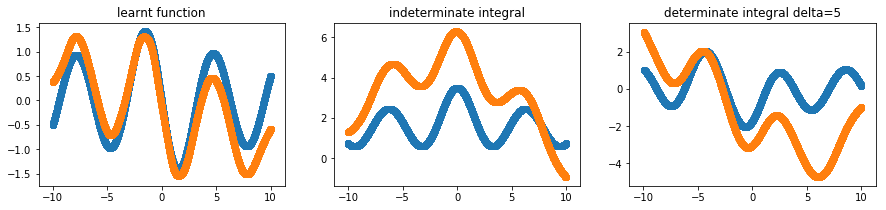

In [141]:
D = 5
plt.figure(figsize=(15,3))
plt.subplot(1,3,1)
plt.title('learnt function')
plt.scatter(xtest[:,0], ytest[:,0])
plt.scatter(xtest[:,0], G.predict(xtest)[:,0])
plt.subplot(1,3,2)
plt.title('indeterminate integral')
plt.scatter(xtest[:,0], lambda_F(xtest[:,0]))
plt.scatter(xtest[:,0], M.predict(xtest)[:,0])
plt.subplot(1,3,3)
plt.title(f'determinate integral delta={D}')
plt.scatter(xtest[:,0], lambda_F(xtest[:,0] + D) - lambda_F(xtest[:,0]))
plt.scatter(xtest[:,0], M.predict(xtest + D)[:,0] - M.predict(xtest)[:,0])
plt.show()